In [ ]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
sys.path.append('..')
import tensorflow as tf
from tensorflow import keras
import cv2 
import shutil 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-ci87mdl2
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-ci87mdl2
     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=b9b2da00d46eca295207cb3b93bd93a8c0085bf2978e271385016becac30e356
  Stored in directory: /tmp/pip-ephem-wheel-cache-ds4u0zph/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [ ]:
#from keras_efficientnets import EfficientNetB0 OLD ONE

from keras.applications.imagenet_utils import decode_predictions
## if you use tensorflow.keras: 
from efficientnet.tfkeras import EfficientNetB0
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = "/content/drive/MyDrive/Food221/train"
validation_dir = "/content/drive/MyDrive/Food221/train"

train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(
					train_dir,
					batch_size = 20,
					class_mode = 'categorical',
					target_size = (112, 112))


validation_generator = test_datagen.flow_from_directory(validation_dir,
														batch_size = 8,
														shuffle = False,
														class_mode = 'categorical',
														target_size = (112, 112))


Found 4900 images belonging to 24 classes.
Found 4900 images belonging to 24 classes.


In [ ]:
# uses Swish Activation Function
from keras.backend import sigmoid
from keras.utils import get_custom_objects
from keras.layers import Activation

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [ ]:
import efficientnet.keras as enet
from keras import layers
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model, Sequential

In [ ]:
# define the model
prior = enet.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg', weights='imagenet')
#freeze the EfficientNetB0 model
# prior.trainable = False

x = prior.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(24, activation="softmax")(x)

modelFirst = Model(inputs = prior.input, outputs = predictions, name="modelFirst")

modelFirst.summary()


16809984/16804768 [==============================] - 1s 0us/step
Model: "modelFirst"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

modelFirst.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, 
        verbose=1, mode='auto', restore_best_weights=True)


history = modelFirst.fit(
			train_generator,
			steps_per_epoch = 100, #datas = batch * steps 
			epochs = 100,
			validation_data = validation_generator,
			validation_steps = 28,
      callbacks=[monitor],
			verbose = 2)

# save model artifact
modelFirst.save('/content/drive/My Drive/models/Model_SnFoodClassif.h5')

Epoch 1/100
100/100 - 1694s - loss: 3.3798 - accuracy: 0.0465 - val_loss: 2.9010 - val_accuracy: 0.3616
Epoch 2/100
100/100 - 869s - loss: 3.1774 - accuracy: 0.0915 - val_loss: 2.4130 - val_accuracy: 0.6027
Epoch 3/100
100/100 - 527s - loss: 2.9509 - accuracy: 0.1405 - val_loss: 1.5377 - val_accuracy: 0.7455
Epoch 4/100
100/100 - 351s - loss: 2.7622 - accuracy: 0.1960 - val_loss: 0.9839 - val_accuracy: 0.8214
Epoch 5/100
100/100 - 204s - loss: 2.6123 - accuracy: 0.2450 - val_loss: 0.9992 - val_accuracy: 0.7768
Epoch 6/100


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 306
  " Skipping tag %s" % (size, len(data), tag)


100/100 - 143s - loss: 2.4459 - accuracy: 0.2960 - val_loss: 0.8451 - val_accuracy: 0.7857
Epoch 7/100
100/100 - 95s - loss: 2.2654 - accuracy: 0.3435 - val_loss: 0.7344 - val_accuracy: 0.7946
Epoch 8/100
100/100 - 67s - loss: 2.1887 - accuracy: 0.3495 - val_loss: 0.7068 - val_accuracy: 0.7545
Epoch 9/100
100/100 - 61s - loss: 2.0498 - accuracy: 0.4095 - val_loss: 0.6799 - val_accuracy: 0.7991
Epoch 10/100
100/100 - 46s - loss: 1.9355 - accuracy: 0.4365 - val_loss: 0.6484 - val_accuracy: 0.8125
Epoch 11/100
100/100 - 45s - loss: 1.8528 - accuracy: 0.4690 - val_loss: 0.5953 - val_accuracy: 0.8348
Epoch 12/100
100/100 - 40s - loss: 1.7455 - accuracy: 0.4955 - val_loss: 0.5989 - val_accuracy: 0.8482
Epoch 13/100
100/100 - 41s - loss: 1.6811 - accuracy: 0.4985 - val_loss: 0.5505 - val_accuracy: 0.8393
Epoch 14/100
100/100 - 41s - loss: 1.6043 - accuracy: 0.5360 - val_loss: 0.4649 - val_accuracy: 0.8929
Epoch 15/100
100/100 - 41s - loss: 1.5156 - accuracy: 0.5450 - val_loss: 0.4411 - val_ac

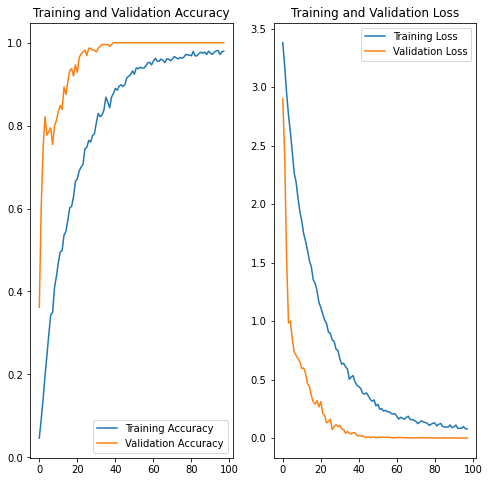

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_dict = train_generator.class_indices
print(class_dict)

{'Akara': 0, 'Caakri': 1, 'Ceeb': 2, 'Ceebu_Joola': 3, 'Cere_Baasi_Salte': 4, 'Cere_Mbuum': 5, 'Cu': 6, 'Daxin': 7, 'Dibi': 8, 'Domoda': 9, 'Fataaya': 10, 'Fiiriir': 11, 'Kaldu': 12, 'Maafe': 13, 'Mbaxalu_Saalum': 14, 'Ndambe': 15, 'Ngalax': 16, 'Ngurbaan': 17, 'Sombi': 18, 'Supp_Yeel': 19, 'Supp_kanja': 20, 'Wermisel': 21, 'Yaasa_Ganaar': 22, 'beignet_Copati': 23}


In [ ]:
li = list(class_dict.keys())
print(li)

Following is our prediction:


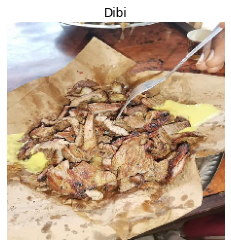

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
image_path = "/content/drive/MyDrive/prediction/test.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = modelFirst.predict(img)

d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]
#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()